# The role of feature Engineering on HAR


## 1. data preparation
The PAMAP2 dataset [1] can be downloaded at:
https://warwick.ac.uk/fac/sci/dcs/people/yu_guan/teaching/pamap2.mat

[1] A. Reiss, D. Stricker, "Introducing a New Benchmarked Dataset for Activity Monitoring", ISWC, 2012

if you use colab, you can upload the dataset via the script below:

from google.colab import files

files.upload()

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import scipy.io


data = scipy.io.loadmat('PAMAP2.mat')
Xy_train0 = data['Xy_train']
Xy_test0 = data['Xy_test']


In [4]:
print('optional: channel-wise normalisation')
mn = np.mean(Xy_train0[:,:-1], axis=0)
std = np.std(Xy_train0[:,:-1], axis=0)
Xy_train0[:,:-1] = (Xy_train0[:,:-1]-mn)/std
Xy_test0[:,:-1] = (Xy_test0[:,:-1]-mn)/std

optional: channel-wise normalisation


In [6]:
cNum=12
win_len = 100
dim = Xy_train0.shape[1]-1 #minus the label col
print(dim)

27


In [8]:
def sliding_window(Xy, percentage=0.5, win_len=100):
    #print('per')
    print('overlapping_percentage:  '+str(percentage*100)+'%')

    batch_size0 = int(np.floor(len(Xy)/win_len))
    #print(batch_size0)
    Xy0 = Xy[:win_len*batch_size0,:]
    if percentage==1:
        print('100% overlapping means no overlapping')
        return Xy0

    K_fold = int(1/(1-percentage))
    #print(K_fold)
    offset = int(np.round(win_len * (1-percentage)))
    Xy_big = []
    for k in range(K_fold):
        #print(k)
        current_set = Xy0[k*offset:len(Xy0)-(win_len-k*offset),:]
        #print(len(current_set))
        Xy_big.append(current_set)
    return np.concatenate(Xy_big)

def _to_frames(Xy, dim, win_len=100):
    X3D = np.reshape(Xy[:,:-1], (-1, win_len, dim))
    y2D = np.reshape(Xy[:,-1],(-1, win_len)).astype(int)
    y = np.zeros(len(y2D))
    for i in range(len(y2D)):
        counts = np.bincount(np.reshape(y2D[i, :], (-1)))
        y[i] = np.argmax(counts)
    return X3D, y

In [10]:
print('original training data shape', Xy_train0.shape)
Xy_train = sliding_window(Xy_train0, 0.5, win_len)
print('after overlapping sliding window', Xy_train.shape)
X_train0, y_train0 = _to_frames(Xy_train,dim, win_len)
print('converting to frames (100 samples per window) with size', X_train0.shape)


#print(Xy_test0.shape)
Xy_test = sliding_window(Xy_test0, 0.5, win_len)
#print(Xy_test.shape)
X_test0, y_test0 = _to_frames(Xy_test,dim,win_len)

original training data shape (473445, 28)
overlapping_percentage:  50.0%
after overlapping sliding window (946600, 28)
converting to frames (100 samples per window) with size (9466, 100, 27)
overlapping_percentage:  50.0%


### We use balanced data, where 'accuracy' is the right measure.

In [13]:
def building_balanced_DB(X, y, cNum, sample_number):
    print('each class will have the same sample number')
    X_new = np.empty([0, win_len, dim])
    y_new = np.empty([0])
    for i in range(cNum):
        if len(X[y==i])<sample_number:
            print('Error: not enough samples for class '+str(i) +'please choose a smaller number')
            break
        else:
            X_new = np.concatenate((X_new, X[y==i][:sample_number]), axis=0)
            #print(X_new.shape)
        
        y_new = np.concatenate((y_new, y[y==i][:sample_number]), axis=0)
        #print(y_new)
    return X_new, y_new
    

In [15]:

print('now it is the balanced data')
size_per_class_train = 250
size_per_class_test = 50
X_train0, y_train0 = building_balanced_DB(X_train0, y_train0, cNum, size_per_class_train)
X_test0, y_test0 = building_balanced_DB(X_test0, y_test0, cNum, size_per_class_test)

   
  
    

now it is the balanced data
each class will have the same sample number
each class will have the same sample number


----------train_Data---------------
class 0, sample number 250, percentage 8.3%
class 1, sample number 250, percentage 8.3%
class 2, sample number 250, percentage 8.3%
class 3, sample number 250, percentage 8.3%
class 4, sample number 250, percentage 8.3%
class 5, sample number 250, percentage 8.3%
class 6, sample number 250, percentage 8.3%
class 7, sample number 250, percentage 8.3%
class 8, sample number 250, percentage 8.3%
class 9, sample number 250, percentage 8.3%
class 10, sample number 250, percentage 8.3%
class 11, sample number 250, percentage 8.3%


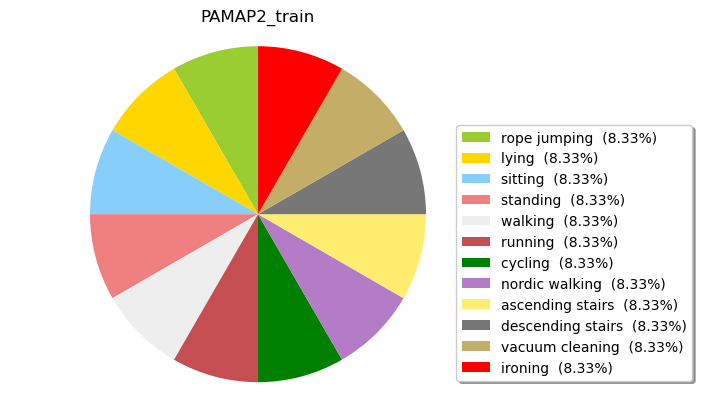

----------testing_Data--------------
class 0, sample number 50, percentage 8.3%
class 1, sample number 50, percentage 8.3%
class 2, sample number 50, percentage 8.3%
class 3, sample number 50, percentage 8.3%
class 4, sample number 50, percentage 8.3%
class 5, sample number 50, percentage 8.3%
class 6, sample number 50, percentage 8.3%
class 7, sample number 50, percentage 8.3%
class 8, sample number 50, percentage 8.3%
class 9, sample number 50, percentage 8.3%
class 10, sample number 50, percentage 8.3%
class 11, sample number 50, percentage 8.3%


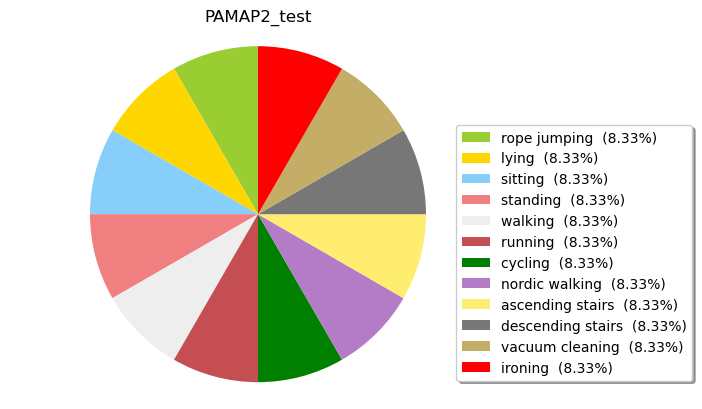

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
def drawing_pie_chart(percentages, labels, dataset_id):
    plt.title(dataset_id)
    color_set = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral',
            '#eeeeee','#C44E52', 'green', '#B47CC7','#ffed6f','#777777','#C4AD66','red', 
                  'blue',  'cyan', 'magenta',
                '#FBC15E','#56B4E9','#4878CF','#FFFEA3' ]
    
    labels = labels.copy()
    for i in range(len(percentages)):
        labels[i] = labels[i]+'  ('+str(percentages[i])[:4]+'%)'
    colors = color_set[:len(percentages)]
    
    
    patches, texts = plt.pie(percentages, colors=colors, startangle=90)
    
    plt.axis('equal')
    lgd = plt.legend(labels, loc=(0.9, 0.05), shadow=True, borderaxespad=10.)
    
    
    #plt.savefig('dataset_'+dataset_id+'.eps', bbox_extra_artists=(lgd,), bbox_inches='tight', format='eps', dpi=600)
    plt.show()
    
def calculating_percentages(y_, cNum):
    percentages = np.zeros(cNum)
    for i in range(cNum):
        num = np.sum(y_==i)
        percentages[i]=100.0*num/len(y_)
        print('class {}, sample number {}, percentage {:.1f}%'.format(i, num, percentages[i]))
    return percentages


dataset_id = 'PAMAP2'
labels_PAMAP2 = [r'rope jumping', 
                 r'lying', 
                 r'sitting', 
                 r'standing',
                 r'walking', 
                 r'running', 
                 r'cycling', 
                 r'nordic walking',
                 r'ascending stairs', 
                 r'descending stairs', 
                 r'vacuum cleaning', 
                 r'ironing']
cNum = 12 # 12 classes for PAMAP2

print('----------train_Data---------------')
percentages_train = calculating_percentages(y_train0, cNum)
drawing_pie_chart(percentages_train,labels_PAMAP2,dataset_id+'_train')

print('----------testing_Data--------------')
percentages_test = calculating_percentages(y_test0, cNum)
drawing_pie_chart(percentages_test,labels_PAMAP2,dataset_id+'_test')

## 2. HAR on Raw data
### Now we directly perform classification on the raw data, and see what happens. First, we have to convert the data into vectors...

In [20]:
print('original dimension:', X_train0.shape)
X_train = np.reshape(X_train0, (-1, dim*win_len))
X_test = np.reshape(X_test0, (-1, dim*win_len))
print('reshaped dimension:', X_train.shape)

y_train = y_train0.copy()
y_test = y_test0.copy()

original dimension: (3000, 100, 27)
reshaped dimension: (3000, 2700)


In [22]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


from time import time
name = ' logistic_regression_classifier '
default_C = 1

t0 = time()
clf = LogisticRegression(penalty='l2',solver = 'lbfgs', C = default_C)
clf.fit(X_train, y_train)
print('training'+name+'takes {:.2f} seconds'.format(time()-t0))


y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('classification accuracy: {:.2f}'.format(acc))
print('random  guess  accuracy: {:.2f}'.format(1/cNum))


training logistic_regression_classifier takes 1.47 seconds
classification accuracy: 0.37
random  guess  accuracy: 0.08


### The accuracy (and training efficiency) is not great ---- we expect more than this, and what is the problem? Maybe we should normalise the features first? 

In [25]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### and try again...

In [28]:
t0 = time()
name = ' logistic_regression_classifier (normalised) '
clf = LogisticRegression(penalty='l2',solver = 'lbfgs', C = default_C)



clf.fit(X_train, y_train)
print(name+'training takes {:.2f} seconds'.format(time()-t0))
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(name+'classification accuracy: {:.2f}'.format(acc))


 logistic_regression_classifier (normalised) training takes 1.57 seconds
 logistic_regression_classifier (normalised) classification accuracy: 0.37


#### No... the result is still bad. Let's try another classifier, SVM (linear)

In [31]:
from sklearn.svm import SVC

t0 = time()
name = ' linear_SVM '



clf = SVC(kernel="linear", C=default_C)




clf.fit(X_train, y_train)
print(name+'training takes {:.2f} seconds'.format(time()-t0))
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(name+'classification accuracy: {:.2f}'.format(acc))


 linear_SVM training takes 5.60 seconds
 linear_SVM classification accuracy: 0.34


#### even worse!  maybe the raw data is not linearly separable? we will try non-linear SVM

In [33]:
t0 = time()
name = ' rbf_SVM '



clf = SVC(kernel="rbf", C=default_C)

clf.fit(X_train, y_train)
print(name+'training takes {:.2f} seconds'.format(time()-t0))
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(name+'classification accuracy: {:.2f}'.format(acc))



 rbf_SVM training takes 9.25 seconds
 rbf_SVM classification accuracy: 0.77


#### Now we see the problem, the raw data is not linearly separable indeed! Now let's use some non-linear classifiers instead!

In [35]:
from sklearn.tree import DecisionTreeClassifier
t0 = time()
name = ' Decision Tree '


clf = DecisionTreeClassifier()



clf.fit(X_train, y_train)
print(name+'training takes {:.2f} seconds'.format(time()-t0))
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(name+'classification accuracy: {:.2f}'.format(acc))



 Decision Tree training takes 5.54 seconds
 Decision Tree classification accuracy: 0.24


#### It was not great, we all know ensemble of decision trees ---- random forest is more powerful, let's try

In [37]:
from sklearn.ensemble import RandomForestClassifier
t0 = time()
name = ' Random forest '



clf = RandomForestClassifier(n_estimators=100)



clf.fit(X_train, y_train)
print(name+'training takes {:.2f} seconds'.format(time()-t0))
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(name+'classification accuracy: {:.2f}'.format(acc))



 Random forest training takes 6.63 seconds
 Random forest classification accuracy: 0.35


#### Structured data is more suitable for decison trees/random forest, maybe we shouldn't directly use these classifiers on raw data 

In [40]:
from sklearn.neighbors import KNeighborsClassifier
t0 = time()
name = ' KNN '

clf = KNeighborsClassifier(5)



clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(name+'classification accuracy: {:.2f}'.format(acc))
print(name+' takes {:.2f} seconds'.format(time()-t0))




 KNN classification accuracy: 0.48
 KNN  takes 0.07 seconds


#### Low dimensional data is more suitable for KNN

### Short summary: non-linear classifier (SVM-rbf) seems work on the raw data, yet decision tree/random forest/knn either required structured data or low dimensional data.  

### Maybe we shouldn't work on the raw data. Next we will do feature engineering to get features that can be 
#### 1) linearly separable . 
#### 2) low dimensional and structured 
### so all the above classifiers can be used. 

## 3. HAR on feature engineered data
#### performing feature engineering

In [48]:
from scipy.stats import iqr, median_abs_deviation 
def _FE(X):
    X_mean = np.mean(X, axis=1)
    X_std = np.std(X, axis=1)
    X_var = np.var(X, axis=1)
    X_energy = np.sqrt(np.mean(np.power(X, 2), axis=1))
    X_mad= np.mean(np.abs(X - np.expand_dims(X_mean, axis=1)), axis=1)
    X_mad1 = median_abs_deviation(X, axis=1)
    X_iqr = iqr(X, axis = 1)
    X_max = np.amax(X, axis=1)
    X_min = np.amin(X, axis=1)
    
    return np.concatenate((X_mean 
                           ,X_std
                           ,X_var
                           ,X_energy
                           ,X_mad
                           ,X_mad1
                           ,X_iqr
                           ,X_max
                           ,X_min
                          ), axis=1)



#print('performing feature engineering')
X_train = _FE(X_train0)
X_test = _FE(X_test0)
print('new feature dimension: '+str(X_train.shape[1]))
y_train = y_train0.copy()
y_test = y_test0.copy()




new feature dimension: 243


In [50]:
print('performing feature-wise normalisation!')
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

performing feature-wise normalisation!


Let's try all the previous classifiers

In [54]:


names = [" _LR ", " SVM ", ' RBF ', " _DT ", " _RF ", " KNN "]

classifiers = [
    
    LogisticRegression(penalty='l2',solver = 'lbfgs', C = default_C),
    SVC(kernel="linear", C=default_C),
    SVC(kernel="rbf", C=default_C),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    KNeighborsClassifier(5)]

for name, clf in zip(names, classifiers):
    t0=time()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(name+'acc: {:.2f}, total_time: {:.2f} sec'.format(acc, time()-t0))
    

   



 _LR acc: 0.79, total_time: 0.25 sec
 SVM acc: 0.72, total_time: 0.29 sec
 RBF acc: 0.87, total_time: 0.51 sec
 _DT acc: 0.73, total_time: 0.42 sec
 _RF acc: 0.90, total_time: 1.78 sec
 KNN acc: 0.87, total_time: 0.02 sec


### We can see significant performance gain
#### logistic regression ----  0.79 (engineered features)        vs    0.37 (raw)
#### linear SVM -------------  0.72 (engineered features)        vs    0.34 (raw)
#### rbf SVM-----------------  0.87 (engineered features)        vs    0.77 (raw)
#### decision tree ----------   0.73 (engineered features)        vs    0.24(raw)
#### random forest ---------  0.90 (engineered features)        vs     0.35 (raw)
#### KNN --------------------  0.87 (engineered features)        vs     0.48 (raw)